In [1]:
%pylab inline
from scipy import ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import sys
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.gridspec as gridspec

sys.path.append('../../../')
from tractionforce.elasticity import *
import gc
from tractionforce.norms import *
from joblib import Parallel, delayed
import multiprocessing
import pickle
import gzip

def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str
    
def extractn(inlist,n):
    try:
        return inlist[n]
    except:
        return None

Populating the interactive namespace from numpy and matplotlib


In [2]:
results_1 = pickle.load(gzip.open('../results/anisotropic_L1_results_expanded_boundary2.gz', 'rb'))
results_2 = pickle.load(gzip.open('../results/anisotropic_L1_results.gz','rb'))
results = [results_1, results_2]
labels = ["Unconstrained", "Constrained"]



In [3]:
x_1 = results[0][-1][0]
y_1 = results[0][-1][1]
for rel in results: del(rel[-1])
x_min, x_max = 69.974999999999994, 133.72999999999999
y_min, y_max = 139.94999999999999, 189.71000000000001

best = []
for j in range(2):
    data_error = [extractn(res,2) for res in results[j]]

    reg_error = [extractn(res,3) for res in results[j]]
    lvals = [extractn(res,4) for res in results[j]]

    # kill all nones

    data_error = [item for item in data_error if item is not None]
    reg_error = [item for item in reg_error if item is not None]
    lvals = [item for item in lvals if item is not None]

    l_curve_distances = np.abs((reg_error[-1]-reg_error[0])*np.array(data_error) -  \
                (data_error[-1]-data_error[0])*np.array(reg_error)+data_error[-1]*reg_error[0]-reg_error[-1]*data_error[0])
    best += [np.argsort(l_curve_distances)[-1]]
    


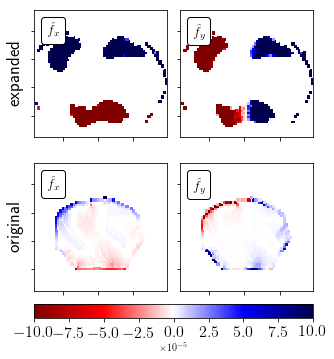

In [4]:
fig = plt.figure(figsize=(5,6))
#fig = plt.figure()
maxmagnitude = 10
gs0 = gridspec.GridSpec(2,1, hspace = 0.1,wspace=0.1)

gs_j = []
gs_j_innergrids = []
ax = []
im = []

labels = ["expanded", "original"]

for j in range(2):
    gs_j += [gridspec.GridSpecFromSubplotSpec(1,2,
                subplot_spec=gs0[j,0],
                  hspace = 0.1,wspace=0.1)]
                #height_ratios = [1,1,1,1,1,1,1])]
    
    Fx = results[j][best[j]][0][:,0].reshape((len(x_1),len(y_1))).transpose()
    Fy = results[j][best[j]][0][:,1].reshape((len(x_1),len(y_1))).transpose()
    # form a new 2x1 subplot of the results
    
    ax += [plt.Subplot(fig, gs_j[j][0,0])]
    fig.add_subplot(ax[-1])
    
    ax[-1].set_xlim((x_min - 15, x_max + 15))
    ax[-1].set_ylim((y_min - 15, y_max + 25))
    #ax[-1].set_ylabel(labels[j],fontsize=18)
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])
    ax[-1].set_ylabel(labels[j],fontsize=18)

    #plt.axis('off')
    
    at = AnchoredText("$\hat{f}_{x}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)

    z = np.ma.masked_array(Fx, np.abs(Fx) < 1e-6)    
    im += [ax[-1].pcolormesh(x_1,y_1,z*1e2, rasterized = True,
                        cmap='seismic_r',vmax = maxmagnitude , vmin=-maxmagnitude )]
    
    im[-1].axes.set_aspect('equal')
    
    ax += [plt.Subplot(fig, gs_j[j][0,1])]
    fig.add_subplot(ax[-1])
    
    ax[-1].set_xlim((x_min - 15, x_max + 15))
    ax[-1].set_ylim((y_min - 15, y_max + 25))
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])
    
    at = AnchoredText("$\hat{f}_{y}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)
    
    z = np.ma.masked_array(Fy, np.abs(Fy) < 1e-6)        
    im += [ax[-1].pcolormesh(x_1,y_1,z*1e2, rasterized= True,
                        cmap='seismic_r',vmax = maxmagnitude , vmin=-maxmagnitude)]
    
    im[-1].axes.set_aspect('equal')
    
#ax[0].text(100,220,r"Unconstrained",fontsize=20)
#ax[2].text(120,220,r"Constrained",fontsize=20)

cb = fig.colorbar(im[0], ax = ax, fraction=0.06, pad=0.04, orientation='horizontal')
cb.ax.tick_params(labelsize=16)
cb.set_label(label=r"$\times 10^{-5}$")

plt.savefig("../../figures/fig10.pdf",bbox_inches='tight', 
               transparent=True,
               pad_inches=0.15, dpi=400)    